<a href="https://colab.research.google.com/github/SkyWaet/Coursework-third-year/blob/main/FrequencyDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Курсовая Работа


In [1]:
import zipfile

#zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Coursework_third_year/new_data.zip', 'r') #Opens the zip file in read mode
#zip_ref.extractall('/new_data') #Extracts the files into the /tmp folder
#zip_ref.close()

train_zip = zipfile.ZipFile('/content/drive/MyDrive/Coursework_third_year/train_11_cor.zip', 'r')
val_zip = zipfile.ZipFile('/content/drive/MyDrive/Coursework_third_year/val_11_cor.zip', 'r')
test_zip = zipfile.ZipFile('/content/drive/MyDrive/Coursework_third_year/test_11_cor.zip', 'r')

train_zip.extractall('/train')
val_zip.extractall('/val')
test_zip.extractall('/test')

train_zip.close()
val_zip.close()
test_zip.close()

from shutil import copy,copyfile
copy('/content/drive/MyDrive/Coursework_third_year/SinDataset.py','/content')

'/content/SinDataset.py'

In [2]:
from shutil import copyfile
copyfile('/content/SinDataset.py','/content/drive/MyDrive/Coursework_third_year/SinDataset.py')

'/content/drive/MyDrive/Coursework_third_year/SinDataset.py'

In [3]:
import torch.optim as optim
import torch
import torch.nn.functional as F
import torch.nn as nn
import time
from torch.utils.data import DataLoader
from SinDataset import SinDataset
from torchvision import transforms
from torchvision import models
from torch.utils.data import random_split
import numpy as np

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
train_path = '/train'
val_path = '/val'
test_path = '/test'

transform = transforms.Compose(
    [transforms.Resize((256, 256)),
     transforms.CenterCrop(224),
     transforms.ToTensor()])

train_ds = SinDataset(info=f'/{train_path}/info.csv', root_dir=f'{train_path}',
                     transform=transform)
val_ds = SinDataset(info=f'/{val_path}/info.csv', root_dir=f'{val_path}',
                     transform=transform)
test_ds = SinDataset(info=f'/{test_path}/info.csv', root_dir=f'{test_path}',
                     transform=transform)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=128, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=128, pin_memory=True,shuffle=True)
print(train_ds[0]['image'].size())

torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.int64


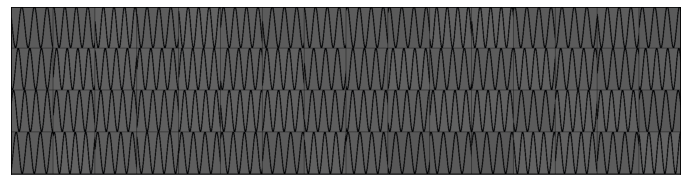

In [6]:
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'
def show_batch(dl):
    for index, elem in enumerate(dl):   
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(elem["image"], nrow=16).permute(1, 2, 0))
        print(elem["frequency"].dtype)
        break
show_batch(train_dl)

In [7]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images = batch["image"].to(self.device,non_blocking=True)
        labels = batch["frequency"].to(self.device,non_blocking=True)  
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):        
        images = batch["image"].to(self.device,non_blocking=True)
        labels = batch["frequency"].to(self.device,non_blocking=True) 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [9]:
class FrequencyDetectorModel(ImageClassificationBase):
    def __init__(self,device):
        super().__init__()
        self.device = device
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(16,16), 

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),        

            nn.Flatten(), 
            nn.Linear(6272, 1024*4),
            nn.ReLU(),            
            nn.Linear(1024*4, 512),
            nn.ReLU(),
            nn.Linear(512, 11),
            nn.LogSoftmax(dim=1))
        
    def forward(self, xb):
        return self.network(xb)

In [10]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for _,batch in enumerate(val_loader)]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    min_loss = np.Inf
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for _,batch in enumerate(train_loader):            
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        if result['val_loss'] < min_loss:
          torch.save(model, '/content/drive/MyDrive/Coursework_third_year/my_model_1.pth')
          min_loss = result['val_loss']
        history.append(result)
        
    return history

In [11]:
model = FrequencyDetectorModel(device).to(device)

In [12]:
evaluate(model, val_dl)

{'val_acc': 0.0792505294084549, 'val_loss': 2.3985118865966797}

In [13]:
num_epochs = 6
opt_func = torch.optim.Adam
lr = 3*10**(-4)

In [14]:
history = fit_old(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.5044, val_loss: 0.1793, val_acc: 0.9343
Epoch [1], train_loss: 0.1636, val_loss: 0.1013, val_acc: 0.9622
Epoch [2], train_loss: 0.0905, val_loss: 0.0372, val_acc: 0.9859
Epoch [3], train_loss: 0.0474, val_loss: 0.0328, val_acc: 0.9880
Epoch [4], train_loss: 0.0330, val_loss: 0.0607, val_acc: 0.9746
Epoch [5], train_loss: 0.0162, val_loss: 0.0142, val_acc: 0.9960


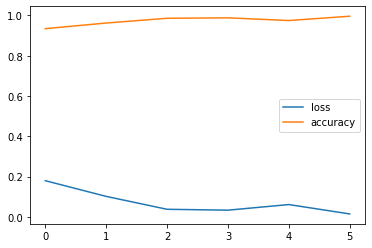

In [20]:
val_losses = [elem['val_loss'] for elem in history]
val_acc = [elem['val_acc'] for elem in history]
plt.plot(val_losses,label="loss")
plt.plot(val_acc, label='accuracy')
plt.legend()

In [21]:
test_model = torch.load('/content/drive/MyDrive/Coursework_third_year/my_model_1.pth')

In [22]:
@torch.no_grad()
def test_accuracy(model,test_dl):
  correct_match = 0
  for i,batch in enumerate(test_dl):
      data = batch["image"].to(device)
      targets = batch["frequency"].to(device)
      res = torch.exp(model(data)) 
      _,out = torch.max(res,dim=1) 
      correct_match += torch.sum(out==targets).item()
  return correct_match/len(test_ds)

In [23]:
print(test_accuracy(test_model,test_dl))

0.9965311004784689
